In [189]:
import pandas as pd
import numpy as np
from queue import PriorityQueue
from numpy import inf
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist

from mpl_toolkits.mplot3d import Axes3D

import random

%matplotlib notebook


In [190]:
# All Data
path_to_file = '/home/lucasperea/Documents/1.A_Dijkstra/Voronoi/EDI.nt2'
alldata = pd.read_csv(path_to_file)


In [216]:
# Transform the output from Zeo++ to Dataframe structure
vertex_table = pd.DataFrame({'coord_x':[], 'coord_y':[], 'coord_z':[],
                             'min_dist_atom':[], 'key':[]})
edge_table = pd.DataFrame({'origin':[], 'destination':[]})

with open(path_to_file) as f:
    line = ' '
    
    while line:
        line = f.readline()
#         
        if line == 'Vertex table:\n':
            while line:
                
                line = f.readline()
                if line == '\n':
                    break
                line_list = line.split()
                key = line_list[0]
                coord_x = float(line_list[1])*6.9
                coord_y = float(line_list[2])*6.9
                coord_z = float(line_list[3])*6.83
                min_dist_atom = float(line_list[4])
                vertex_table = vertex_table.append({'coord_x':coord_x, 'coord_y':coord_y, 'coord_z':coord_z,
                                                    'min_dist_atom':min_dist_atom, 'key':key},ignore_index = True)
        elif line == 'Edge table:\n':
            
            while line:
                
                line = f.readline()
                if line == '':
                    break
                line_list = line.split()
                origin = line_list[0]
                destination = line_list[2]
                larger_radius = float(line_list[3])
                x_sim = int(line_list[4])
                y_sim = int(line_list[5])
                z_sim = int(line_list[6])
                edge_table = edge_table.append({'origin':origin, 'destination': destination, 'x_sim':x_sim,
                                                'y_sim':y_sim, 'z_sim':z_sim,'larger_radius':larger_radius},
                                               ignore_index = True)

        
        

In [217]:
dim = 3

# Box's size took it from the cif file
box = np.array([6.9260, 6.9260, 6.4100])

# Function for the calculation of distances between axes
def distance(origin, destination, vertex_table, box):
    
    dim = 3

    p1 = vertex_table.loc[vertex_table['key'] == origin, ['coord_x', 'coord_y', 'coord_z']].values[0]
    p2 = vertex_table.loc[vertex_table['key'] == destination, ['coord_x', 'coord_y', 'coord_z']].values[0]
    
    dist_3d = np.zeros((dim))
    for j in range(dim):
        dist = abs(p2[j]-p1[j])
        if dist > box[j] * 0.5:
            dist = abs(box[j] - dist)
        dist_3d[j] = dist
    
    
    return np.sqrt(np.sum(np.power(dist_3d, 2)))

# Calculation of the edge's distances
edge_dist = edge_table.apply(lambda x: distance(x[0], x[1], vertex_table, box), axis=1)
edge_table = edge_table.assign(edge_dist=edge_dist)

In [218]:
class Graph:

    def __init__(self, num_of_vertices, dist_mat):
        self.v = num_of_vertices
        self.edges = dist_mat
        self.visited = []
        
    def add_edge(self, u, v, weight):
        self.edges[u][v] = weight
        self.edges[v][u] = weight
        
    def dijkstra(self, start_vertex, target, parents):
        
        # Dictionary with keys = vertices and values = weights of the vertices (set as infinity at the start)
        D = {}
        D = {v:float('inf') for v in range(self.v)}
        D[start_vertex] = 0

        pq = PriorityQueue()
        pq.put((0, start_vertex))

        while not pq.empty():
            (dist, current_vertex) = pq.get()
            if current_vertex == target:
                print('Target vertex: ' + str(target) + ' reached')
                break
            else:
                
                self.visited.append(current_vertex)
                

                # Loop for every vertex of the net
                for neighbor in range(self.v):
                    if self.edges[current_vertex][neighbor] != -1:
                        distance = self.edges[current_vertex][neighbor]
                        if neighbor not in self.visited:
                            old_cost = D[neighbor]
                            new_cost = D[current_vertex] + distance
                            if new_cost < old_cost:
                                pq.put((new_cost, neighbor))
                                D[neighbor] = new_cost
                                parents[str(neighbor)] = current_vertex
        
        return D, parents
    
    def backpedal(self, start_vertex, target, searchResult):

        node = str(target)

        backpath = [node]

        path = []

        while node != str(start_vertex):

            backpath.append(str(searchResult[node]))

            node = str(searchResult[node])

        for i in range(len(backpath)):

            path.append(backpath[-i - 1])

        return path

In [219]:
list_nodes = [int(num) for num in list(vertex_table['key'])]
len(list_nodes)

69

In [245]:
# initialization of the Graph and distance Matrix

list_nodes = [int(num) for num in list(vertex_table['key'])]

N = len(list_nodes)
dist_mat = np.ones((N, N))*-1
g = Graph(N, dist_mat)

# Dictionary to translate from nodes to his position in vertex_table

list_nodes = [num for num in range(len(vertex_table))]

N = len(list_nodes)

trans_pos_nod = {}
for i in range(N):
    trans_pos_nod[str(i)] = int(vertex_table['key'][i])
    
trans_nod_pos = {}
for i in range(len(vertex_table['key'])):
    trans_nod_pos[vertex_table['key'][i]] = i


radius_mat = np.ones(dist_mat.shape)

# Loop to create conexion between the nodes
for i in range(len(edge_table)):
    origin = edge_table.iloc[i,0]
    destination = edge_table.iloc[i,1]
    
    origin_index = vertex_table.loc[vertex_table['key'] == origin].index.values[0]
    destination_index = vertex_table.loc[vertex_table['key'] == destination].index.values[0]
    
 
    dist_mat[origin_index, destination_index] = edge_table.iloc[i, 6]
    radius_mat[origin_index, destination_index] = edge_table.iloc[i, 2]

In [257]:
g = Graph(N, dist_mat)

parents = {}


origin = random.choice(list_nodes)
destination = random.choice(list_nodes)
print(origin, destination)

D, P = g.dijkstra(origin, destination, parents)
print(P)
path = g.backpedal(str(origin), str(destination), P)

node_path = []

for part in path:
    node_path.append(trans_pos_nod[part])
    
print(node_path)

3 7
Target vertex: 7 reached
{'4': 3, '7': 3, '8': 3, '10': 3, '28': 3, '0': 8, '5': 8, '9': 8, '25': 8, '14': 5, '17': 25, '18': 25, '21': 25}
[3, 7]


In [258]:
# Matrix with the cartesians coordinates of all the nodes in the system
pos_mat = np.zeros((N, dim))

for i in range(N):
    pos_mat[i,:] = vertex_table.loc[vertex_table.index == i, ['coord_x', 'coord_y', 'coord_z']].values[0]

In [259]:
# # Supercell for EDI 
# from pymatgen.core.structure import Structure
# path_file = '/home/lucasperea/Documents/1.A_Dijkstra/Voronoi/EDI.cif'
# edi = Structure.from_file(path_file)
# # edi.make_supercell([2,2,2])
# # edi.make_supercell([[2,0,0],[0,2,0],[0,0,2]])
# # edi.make_supercell([[-2,0,0],[0,-2,0],[0,0,-2]])
# len(edi)


In [260]:

interdata = {'pos_mat': pos_mat, 'node_path':node_path, 'path':path, 'dist_mat':dist_mat}
%store interdata

Stored 'interdata' (dict)


In [265]:
%store -r sep_dic
%store -r sep_list

In [270]:
import pickle

with open('/home/lucasperea/Documents/1.A_Dijkstra/Voronoi/sep_list', 'wb') as handle:
    pickle.dump(sep_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

<IPython.core.display.Javascript object>


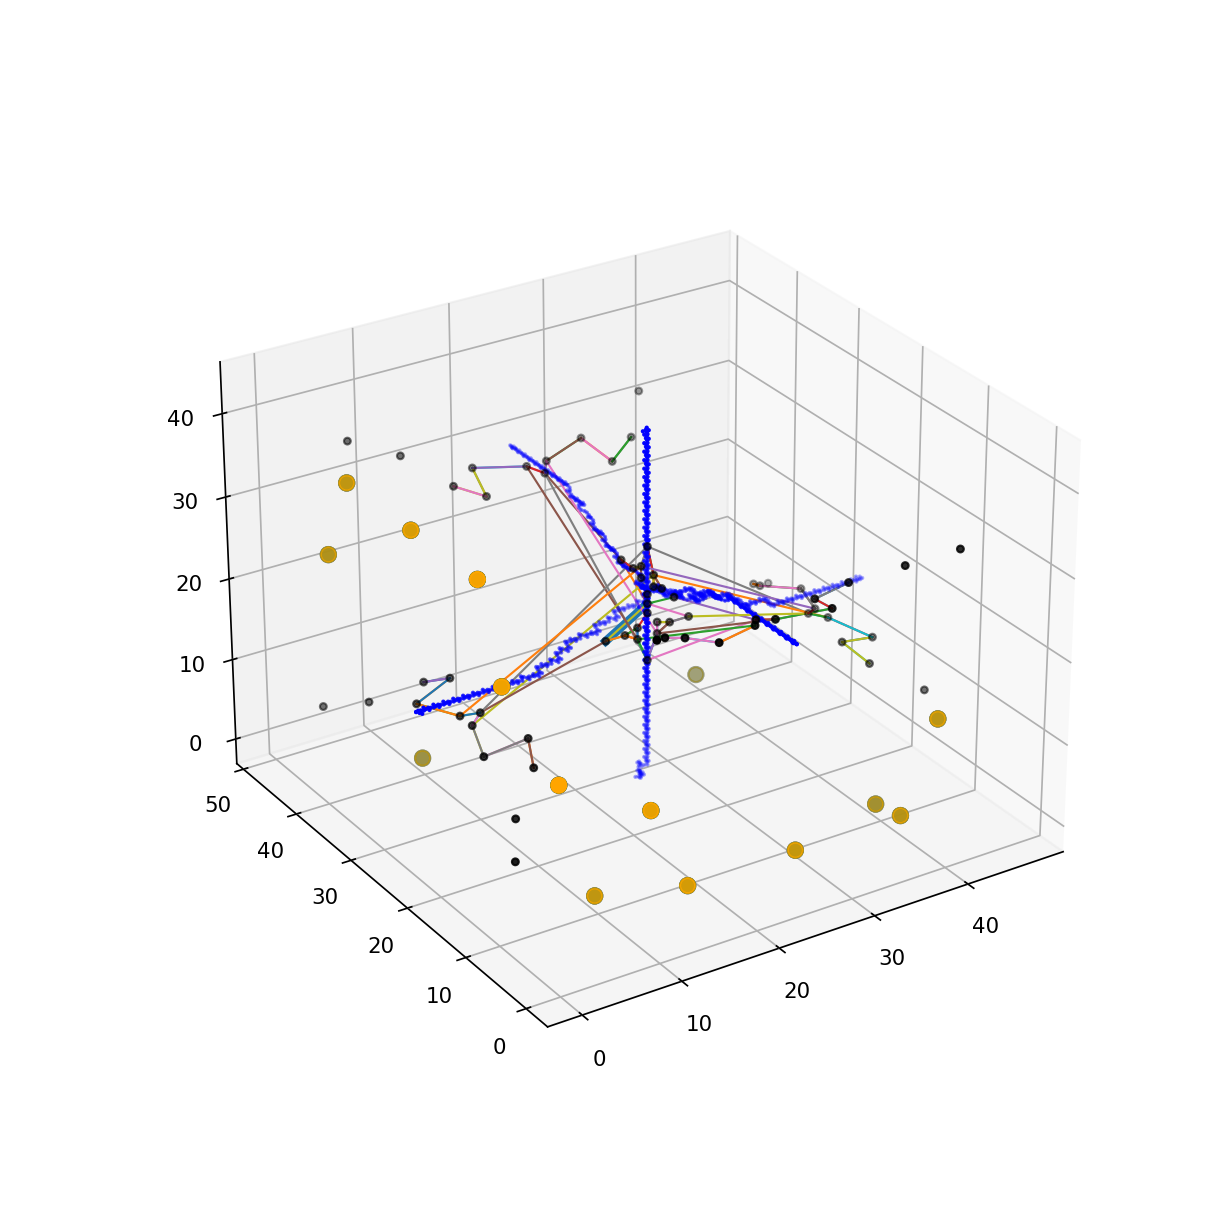

In [268]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

for i in range(len(node_path)-1):

    ax.plot([pos_mat[int(path[i])][0], pos_mat[int(path[i+1])][0]], 
            [pos_mat[int(path[i])][1], pos_mat[int(path[i+1])][1]],
            zs=[pos_mat[int(path[i])][2], pos_mat[int(path[i+1])][2]], linewidth=4)
    
    
x_ax = pos_mat[:,0]
y_ax = pos_mat[:,1]
z_ax = pos_mat[:,2]

ax.scatter(x_ax,y_ax,z_ax, s=10, c='black') 

# separatrices points
for key in sep_dic:
    
    x_sep = sep_dic[key][:,0]
    y_sep = sep_dic[key][:,1]
    z_sep = sep_dic[key][:,2]

    ax.scatter(x_sep,y_sep,z_sep, s=1, c='blue') 


# for i in range(len(dist_mat)):
#     for j in range(len(dist_mat)):
#         if dist_mat[i,j] == -1:
#             pass
#         else: 
#             ax.plot([pos_mat[i, 0], pos_mat[j, 0]], 
#                     [pos_mat[i, 1], pos_mat[j, 1]],
#                     zs=[pos_mat[i, 2], pos_mat[j, 2]], linewidth=4)
ax.scatter(edi.cart_coords[:,0]*6.9,edi.cart_coords[:,1]*6.9, edi.cart_coords[:,2]*6.83, s=50, c='blue') 
ax.scatter(edi.cart_coords[:,0]*6.9,edi.cart_coords[:,1]*6.9, edi.cart_coords[:,2]*6.83, s=50, c='green') 
ax.scatter(edi.cart_coords[:,0]*6.9,edi.cart_coords[:,1]*6.9, edi.cart_coords[:,2]*6.83, s=50, c='orange') 


for i in range(len(dist_mat)):
    for j in range(len(dist_mat)):
        if dist_mat[i, j] == -1:
            pass
        elif np.sqrt(np.sum(np.power(pos_mat[i,:] - pos_mat[j,:], 2))) < max(dist_mat[i,:]) and 0.25 < radius_mat[i,j]:
            ax.plot([pos_mat[i,0], pos_mat[j,0]], 
                    [pos_mat[i, 1], pos_mat[j, 1]],
                    zs=[pos_mat[i, 2], pos_mat[j, 2]], linewidth=1)
    

In [262]:
np.sum(edge_table['larger_radius'])/len(edge_table['larger_radius'])
np.array(edge_table['larger_radius'])[np.array(edge_table['larger_radius'])<0.1]
len(edge_table['larger_radius'])

278

In [263]:
def distance_non(origin, destination, vertex_table, box):
    
    dim = 3

    p1 = vertex_table.loc[vertex_table['key'] == origin, ['coord_x', 'coord_y', 'coord_z']].values[0]
    p2 = vertex_table.loc[vertex_table['key'] == destination, ['coord_x', 'coord_y', 'coord_z']].values[0]
    
    dist_3d = np.zeros((dim))
    for j in range(dim):
        dist = abs(p2[j]-p1[j])
        dist_3d[j] = dist
    
    
    return np.sqrt(np.sum(np.power(dist_3d, 2)))

edge_dist_non = edge_table.apply(lambda x: distance_non(x[0], x[1], vertex_table, box), axis=1)

for i in range(len(edge_table)):
    origin = edge_table.iloc[i,0]
    destination = edge_table.iloc[i,1]
    
    origin_index = vertex_table.loc[vertex_table['key'] == origin].index.values[0]
    destination_index = vertex_table.loc[vertex_table['key'] == destination].index.values[0]
    
 
    dist_mat[origin_index, destination_index] = edge_table.iloc[i, 6]